In [1]:
# Parsing ascii files from the eyelink into eye position and data table files
# Clara Kuper, September 2020

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import ipywidgets as widgets

In [2]:
# get the files, this will be set up in a bigger loop later
# open files and read them 
# todo:
# write out every new presentation of a target
# write out all saccade onsets
# find the point when both fixated, set this as trial_start

# next: plot the location of the stimuli
# next: compare timing from eyelink and other data.

f = open('../edf/test_NS.asc','r')
l = f.readlines()
read = False
time_start = 4
time_end = 11
line = 0

# read the file till the first block starts (discarding all information before)
while not read:
    if l[line].find('EXPERIMENT STARTED')>=0:
        start_id = line
        read = True
    line += 1

# set up the tables where we will save the data.
# there will be two of them, one for the continuous eye position, one for the responses and message timing
raw_list = [] # for eye position data
events = [] # for time stamps of events
tr_nr = 0 # set the trial number to 0
block_nr = 0 # set the block number to 0
mov_type = 'unknown' # unknown, saccade, blink, fixation
in_trial = False # we only want the eye position when the trial has started (after trial_start)

for line in l[start_id:]:
    
    # additional information for the table
    append_message = [block_nr, tr_nr, mov_type]
    
    if line[0:3].isnumeric(): # either the line starts with a number (time stamp), or with a string (message or detected movement)
            position_data = np.hstack((line.split(),append_message))
            #print(position_data)
            raw_list.append(position_data)
        
    else: 
            
        if line.find('BLOCK_START')>=0:
            block = line.find('BLOCK_START')
            block_nr = int(line[block+len('BLOCK_START')+2:])
            
        if line.find('TRIAL_SYNCTIME')>=0:
            sync = line.find('TRIAL SYNCTIME')
            sync_t = int(line[time_start:time_end])
            
        if line.find('TRIAL_START')>=0:
            start = line.find('TRIAL_START')
            start_t = line[time_start:time_end]
            tr_nr = int(line[start+len('TRIAL_START')+2:])
            
            # set all values to read out to none
            stim_on = None
            eyes_fix = None
            kb_down = None
            att_moved = None
            hand_moved = None
            att_dis = None
            hand_stopped = None
            att_goal = None
            feedback_shown = None
            response_cat = None
            
            in_trial = True
            
        if line.find('EXPERIMENT_END')>=0:
            break
    

        if in_trial:
            
            if line[0:3]=='MSG':
                
                # get time write to table
                if line.find('STIM_ON_SCREEN')>=0:
                    stim_on = int(line[time_start:time_end])
                    
                if line.find('EYES_FIXATED')>=0:
                    eyes_fix = int(line[time_start:time_end])
                    
                if line.find('KEYBOARD_DOWN')>=0:
                    kb_down = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_MOVED')>=0:
                    att_moved = int(line[time_start:time_end])
                    
                if line.find('START_HAND_MOVEMENT')>=0:
                    hand_moved = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_DISAPPEARED')>=0:
                    att_dis = int(line[time_start:time_end])
                    
                if line.find('END_HAND_MOVEMENT')>=0:
                    hand_stopped = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_REACHED_GOAL')>=0:
                    att_goal = int(line[time_start:time_end])
                    
                if line.find('FEEDBACK_PRESENTED')>=0:
                    feedback_shown = int(line[time_start:time_end])
                    
                if line.find('RESPONSE_TRIAL')>=0:
                    line_parsed = line.split(', ')
                    response_cat = line_parsed[-1]
                    response_cat = response_cat[0:-1]
        
                if line.find('TRIAL_END')>=0:
            
                    end_t = line[time_start:time_end]
                    trial_events = [block_nr, tr_nr, sync_t, stim_on, eyes_fix, kb_down, att_moved, 
                                    hand_moved, att_dis, hand_stopped, att_goal, feedback_shown, response_cat]
                    events.append(trial_events)
                    in_trial = False
                
            else:
                # define eye movement types
                if line.find('SSACC')>=0:
                    mov_type = 'saccade'
            
                if line.find('ESACC')>=0:
                    mov_type = 'unknown'
            
                if line.find('SFIX')>=0:
                    mov_type = 'fixation'
            
                if line.find('EFIX')>=0:
                    mov_type = 'unknown' 
            
                if line.find('SBLINK')>=0:
                    mov_type = 'blink'

                if line.find('EBLINK')>=0:
                    mov_type = 'unknown'


In [3]:
event_data = pd.DataFrame(events, columns = ['block', 'trial', 'sync', 'stim_on', 'eyes_fix', 'kb_down',
                                            'att_moved', 'hand_moved', 'att_dis', 'hand_stopped', 'att_goal',
                                            'feedback_shown', 'response_cat'])
event_data

,block,trial,sync,stim_on,eyes_fix,kb_down,att_moved,hand_moved,att_dis,hand_stopped,att_goal,feedback_shown,response_cat
0,1,1,4659976,4659982,4660266,4661443,4661996,4662366.0,4662416,4662608.0,4662708,4662710,HIT
1,1,2,4662972,4662982,4663216,4663474,4664029,4664366.0,4664449,4664633.0,4664732,4664734,FALSE ALARM
2,1,3,4664993,4664999,4665566,4665475,4666120,4666482.0,4666541,4666724.0,4666824,4666825,FALSE ALARM
3,1,4,4667081,4667091,4667841,4667491,4668395,4668799.0,4668816,4669049.0,4669099,4669101,FALSE ALARM
4,1,5,4669369,4669374,4669549,4669825,4670379,NaN,4670799,NaN,4671083,4671085,MISS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2,38,4852024,4852034,4852217,4852034,4852771,NaN,4853192,NaN,4853475,4853476,CORRECT REJECTION
82,2,39,4853734,4853742,4853992,4853742,4854546,NaN,4854967,NaN,4855250,4855251,MISS
83,2,40,4855509,4855517,4855717,4855776,4856329,4856767.0,4856750,4856984.0,4857034,4857034,HIT
84,2,41,4857292,4857300,4857625,4857692,4858246,NaN,4858667,NaN,4858952,4858953,MISS


In [4]:
eye_position = pd.DataFrame(raw_list, columns = ['time', 'x_pos', 'y_pos', 'pupil', 'right','block', 'trial', 'move_type'])
eye_position

,time,x_pos,y_pos,pupil,right,block,trial,move_type
0,4659941,922.8,194.3,1815.0,...,1,0,unknown
1,4659942,922.8,194.3,1812.0,...,1,0,unknown
2,4659943,922.7,194.3,1812.0,...,1,0,unknown
3,4659944,922.6,195.1,1813.0,...,1,0,unknown
4,4659945,922.6,195.1,1813.0,...,1,0,unknown
...,...,...,...,...,...,...,...,...
178724,4860764,1651.2,395.2,1741.0,...,2,42,fixation
178725,4860765,1651.1,395.4,1737.0,...,2,42,fixation
178726,4860766,1650.8,395.4,1737.0,...,2,42,fixation
178727,4860767,1650.6,395.4,1737.0,...,2,42,fixation


In [5]:
no_x_pos_available = np.where(eye_position['x_pos'] == '.')
no_y_pos_available = np.where(eye_position['y_pos'] == '.')
no_pupil_available = np.where(eye_position['pupil'] == '.')

eye_position['x_pos'].iloc[no_x_pos_available] = '0'
eye_position['y_pos'].iloc[no_y_pos_available] = '0'
eye_position['pupil'].iloc[no_pupil_available] = '0'

eye_position['time'] = pd.to_numeric(eye_position['time'])
eye_position['x_pos'] = pd.to_numeric(eye_position['x_pos'])
eye_position['y_pos'] = pd.to_numeric(eye_position['y_pos'])
eye_position['pupil'] = pd.to_numeric(eye_position['y_pos'])
eye_position['trial'] = pd.to_numeric(eye_position['trial'])
eye_position['block'] = pd.to_numeric(eye_position['block'])

In [40]:
# visualize eye position per trial
def plot_func(trial, block):
    #get index to trial
    data_id_trial = np.where(eye_position['trial']== trial)[0]
    data_id_block = np.where(eye_position['block']==block)[0]
    trial_data = eye_position.iloc[np.intersect1d(data_id_trial, data_id_block)]
    
    #get index to block
    event_id_trial = np.where(event_data['trial']== trial)[0]
    event_id_block = np.where(event_data['block']==block)[0]
    trial_events = event_data.iloc[np.intersect1d(event_id_trial, event_id_block)]
    print(trial_events['sync'].values)
    print(trial_events['att_moved'].values)
    
    trial_data['time'] = trial_data['time'].values - trial_events['sync'].values
    groups = trial_data.groupby('move_type')
    fig, axs = plt.subplots(1,1)
    for name, group in groups:
        axs.scatter(group['time'], group['y_pos'])
        axs.scatter(group['time'], group['x_pos'])
        axs.set_xlim([0,3000])
        axs.set_ylim([0,2000])
    axs.axvline(x=trial_events['att_moved'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'go', color = 'r')
    axs.axvline(x=trial_events['eyes_fix'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'fixEyes', color = 'g')
    axs.axvline(x=trial_events['kb_down'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'fixHand', color = 'b')
    axs.axvline(x=trial_events['hand_moved'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'moveOn', color = 'c')
    axs.axvline(x=trial_events['hand_stopped'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'moveOff', color = 'm' )
    axs.axvline(x=trial_events['att_goal'].values-trial_events['sync'].values,ymin = 0, ymax = 2000, label = 'attGoal', color = 'y')
    
    axs.legend(loc = 2)


trial_slider = widgets.IntSlider(min=1,
    max=tr_nr,                          
    step=1,
    description='Trial No:',
    value=1,
    continuous_update = False) #difference units drift

block_slider = widgets.IntSlider(min=1,
    max=block_nr,                          
    step=1,
    description='Block No:',
    value=1,
    continuous_update = False) #difference units drift

widgets.interact(plot_func, trial = trial_slider,block = block_slider)

    

interactive(children=(IntSlider(value=1, continuous_update=False, description='Trial No:', max=42, min=1), Int…

<function __main__.plot_func(trial, block)>

(array([ 1., 32., 46.,  5.,  1.,  0.,  0.,  0.,  1.]),
 array([703., 704., 705., 706., 707., 708., 709., 710., 711., 712.]),
 <a list of 9 Patch objects>)

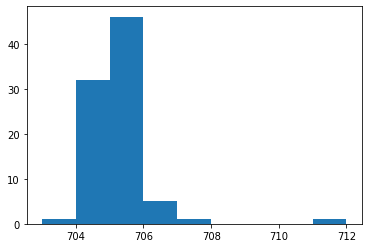

In [48]:
plt.hist(event_data['att_goal']-event_data['att_moved'], bins =9)